# Caracterização de Workload

Este Notebook tem o objetivo de analizar um arquivo de logs de um servidor web e realizar uma analise de caracterização de workload para teste levando em considerações os padrões de utilização.

### Grupo:
Leonardo Menezes <br>
Lucas <br>
Pedro Martins dos Santos

## Importando o arquivo de logs

In [27]:
import pandas as pd
import re
import matplotlib.pyplot as plt

# Caminho do arquivo de log
log_file_path = 'access.log'

# Padrão regex para capturar informações válidas
regex_pattern = r'^(?P<client>\S+) \S+ (?P<userid>\S+) \[(?P<datetime>[^\]]+)\] "(?P<method>[A-Z]+) (?P<request>[^"]+)? HTTP/[0-9.]+" (?P<status>\d{3}) (?P<size>\d+|-) "(?P<referer>[^"]*)" "(?P<user_agent>[^"]*)"'

# Definição das colunas
columns = ['client', 'userid', 'datetime', 'method', 'request', 'status', 'size', 'referer', 'user_agent']

# Listas para armazenar entradas válidas e inválidas
valid_entries = []
invalid_entries = []

with open(log_file_path, 'r') as file:
    for i, line in enumerate(file):
        if i >= 10_000_000:  # Limite opcional para processar somente 1 milhão de linhas
            break
        match = re.match(regex_pattern, line)
        if match:
            valid_entries.append({
                'client': match.group('client'),
                'userid': match.group('userid'),
                'datetime': match.group('datetime'),
                'method': match.group('method'),
                'request': match.group('request'),
                'status': int(match.group('status')),
                'size': int(match.group('size')) if match.group('size') != '-' else 0,
                'referer': match.group('referer'),
                'user_agent': match.group('user_agent')
            })
        else:
            invalid_entries.append(line)

# Criação do DataFrame para entradas válidas
logs_df = pd.DataFrame(valid_entries, columns=columns)

# Salvar entradas inválidas para análise posterior
with open('invalid_entries.log', 'w') as invalid_file:
    for line in invalid_entries:
        invalid_file.write(line)

# Exibir informações gerais
print(f"Entradas válidas: {len(valid_entries)}")
print(f"Entradas inválidas: {len(invalid_entries)}")

Entradas válidas: 9999923
Entradas inválidas: 77


## Removendo colunas que não usaremos

In [32]:
new_logs_df = logs_df.drop(["userid","method"], axis='columns')

In [33]:
new_logs_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9999923 entries, 0 to 9999922
Data columns (total 7 columns):
 #   Column      Dtype 
---  ------      ----- 
 0   client      object
 1   datetime    object
 2   request     object
 3   status      int64 
 4   size        int64 
 5   referer     object
 6   user_agent  object
dtypes: int64(2), object(5)
memory usage: 534.1+ MB


## Ajustando o Datetime

In [34]:
new_logs_df['datetime'] = pd.to_datetime(new_logs_df['datetime'], format='%d/%b/%Y:%H:%M:%S %z')

In [35]:
date = new_logs_df['datetime'].dt.minute
print(date)

0          56
1          56
2          56
3          56
4          56
           ..
9999918    52
9999919    52
9999920    52
9999921    52
9999922    52
Name: datetime, Length: 9999923, dtype: int32


In [36]:
teste_df = new_logs_df.groupby(['datetime']).count()
print(teste_df)

                           client  request  status  size  referer  user_agent
datetime                                                                     
2019-01-22 03:56:14+03:30       1        1       1     1        1           1
2019-01-22 03:56:16+03:30       2        2       2     2        2           2
2019-01-22 03:56:17+03:30       3        3       3     3        3           3
2019-01-22 03:56:18+03:30       5        5       5     5        5           5
2019-01-22 03:56:19+03:30       7        7       7     7        7           7
...                           ...      ...     ...   ...      ...         ...
2019-01-26 17:52:15+03:30      34       34      34    34       34          34
2019-01-26 17:52:16+03:30      24       24      24    24       24          24
2019-01-26 17:52:17+03:30      41       41      41    41       41          41
2019-01-26 17:52:18+03:30      47       47      47    47       47          47
2019-01-26 17:52:19+03:30      21       21      21    21       2

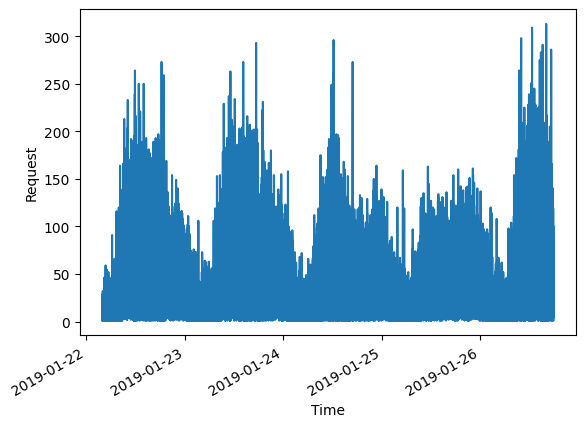

In [37]:
teste_df.request.plot()
plt.xlabel('Time')
plt.ylabel('Request')
plt.show()

## Histograma

<Axes: ylabel='Frequency'>

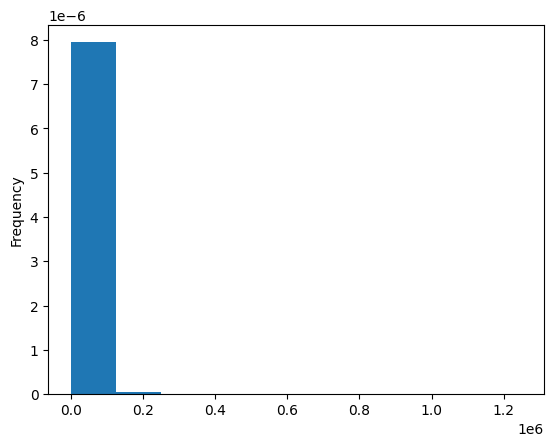

In [38]:
ylabel='Packet size'
new_logs_df["size"].plot(kind = 'hist', density=True)

## Quantidade de pacotes por tamanho

In [39]:
size_count  = new_logs_df['size'].value_counts()
display(size_count.head(20))

size
0        746281
4120     337539
11       240571
28536    109782
323       99838
5807      93532
7713      93239
6496      92733
7356      92699
6454      91367
133       86744
7146      82702
4859      82000
3863      81849
178       60944
62894     53099
5         36732
392       35682
152       32782
358       32313
Name: count, dtype: int64

## Maiores pacotes

In [40]:
tamanho  = new_logs_df.sort_values(by='size',ascending=False)
display(tamanho.head(20))

,client,datetime,request,status,size,referer,user_agent
181242,40.77.167.13,2019-01-22 08:54:13+03:30,/image/5795?name=lg_13541539..3.png&wh=max,200,1249490,-,Mozilla/5.0 (compatible; bingbot/2.0; +http://...
641245,207.46.13.199,2019-01-22 11:56:57+03:30,/image/5883?name=lg_1.....png&wh=max,200,1147355,-,Mozilla/5.0 (compatible; bingbot/2.0; +http://...
7049818,91.251.165.139,2019-01-25 13:21:05+03:30,/image/5801?name=er217%2C%2C%2C....png&wh=max,200,1126965,https://www.zanbil.ir/product/5801/6386/%D9%85...,Mozilla/5.0 (Windows NT 6.1; Win64; x64) Apple...
1240625,37.254.0.202,2019-01-22 15:49:17+03:30,/image/5801?name=er217%2C%2C%2C....png&wh=max,200,1126965,https://www.zanbil.ir/m/product/5801/6386/%D9%...,Mozilla/5.0 (Linux; Android 6.0.1; Lenovo TB2-...
7072109,91.251.165.139,2019-01-25 13:34:04+03:30,"/image/5801?wh=max&name=er217,,,....png",200,1126965,https://www.zanbil.ir/product/5801/6386/%D9%85...,Mozilla/5.0 (Windows NT 6.1; Win64; x64) Apple...
8075789,85.133.194.178,2019-01-25 22:55:36+03:30,/image/5801?name=er217%2C%2C%2C....png&wh=max,200,1126965,https://www.zanbil.ir/product/5801/6386/%D9%85...,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.14; ...
7276007,5.126.31.243,2019-01-25 15:31:33+03:30,/image/5801?name=er217%2C%2C%2C....png&wh=max,200,1126965,https://www.zanbil.ir/product/5801/6386/%D9%85...,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...
1143366,37.27.89.61,2019-01-22 15:10:20+03:30,/image/5801?name=er217%2C%2C%2C....png&wh=max,200,1126965,https://www.zanbil.ir/product/5801/6386/%D9%85...,Mozilla/5.0 (Windows NT 6.1; rv:64.0) Gecko/20...
7959846,93.117.119.126,2019-01-25 22:00:03+03:30,/image/5801?name=er217%2C%2C%2C....png&wh=max,200,1126965,https://www.zanbil.ir/product/5801/6386/%D9%85...,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...
149279,185.180.53.254,2019-01-22 08:35:53+03:30,/image/5801?name=er217%2C%2C%2C....png&wh=max,200,1126965,https://www.zanbil.ir/product/5801/6386/%D9%85...,Mozilla/5.0 (Windows NT 6.1; rv:45.0) Gecko/20...


## Quantidade de chamadas por Cliente

In [41]:
client_count  = new_logs_df['client'].value_counts()
display(client_count.head(20))

client
66.249.66.194      345852
66.249.66.91       306901
151.239.241.163     89518
66.249.66.92        84735
91.99.30.32         45973
91.99.72.15         37849
5.78.190.233        37203
91.99.47.57         35461
23.101.169.3        27199
195.181.168.181     26692
104.222.32.91       25044
195.181.168.164     24043
17.58.102.43        21668
66.249.66.93        21260
104.222.32.94       16706
5.117.116.238       13422
5.160.157.20        13223
5.160.221.38        12001
172.20.2.174        11044
207.46.13.60         9958
Name: count, dtype: int64

## Quantidade de Request por client

In [42]:
display(client_count.describe())

count    249999.000000
mean         39.999852
std         986.446391
min           1.000000
25%           1.000000
50%           3.000000
75%          33.000000
max      345852.000000
Name: count, dtype: float64

## Quantidade de Request por Status

In [43]:
status_count  = new_logs_df['status'].value_counts()
display(status_count.head(20))

status
200    9247173
304     330941
302     193558
404     102156
301      66716
499      49055
403       5497
500       3053
502        782
400        521
401        255
408        106
504        101
405          6
206          3
Name: count, dtype: int64

## Códigos de Status HTTP
200 = Sucesso (OK) <br>
301 = Redirecionamento (Moved Permanently)<br>
302 = Redirecionamento (Found)<br>
304 = Redirecionamento (Not Modified)<br>
404 = Conteúdo não encontrado (Not Found)<br>

<Axes: xlabel='Status', ylabel='Quantidade'>

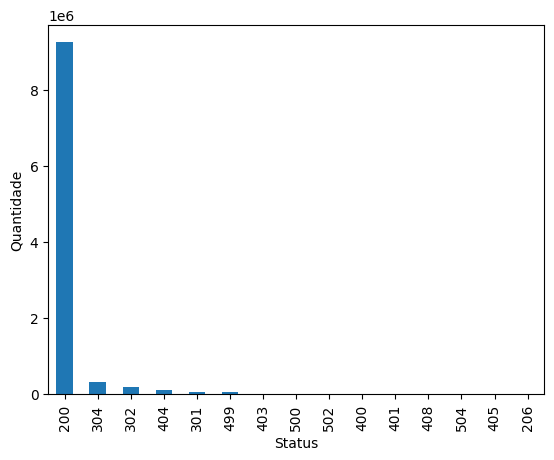

In [44]:
new_logs_df["status"].value_counts().plot(kind = 'bar', x='status', y='value', ylabel='Quantidade',xlabel='Status')

In [79]:
new_logs_df['datetime'] = pd.to_datetime(new_logs_df['datetime'], format='%d/%b/%Y:%H:%M:%S %z')

specific_day = '2019-01-23'
filtered_logs = new_logs_df[new_logs_df['datetime'].dt.strftime('%Y-%m-%d') == specific_day]

filtered_logs['hour'] = filtered_logs['datetime'].dt.hour

hourly_grouped = filtered_logs.groupby('hour').agg(
    total_requests=('request', 'count'),
    total_size=('size', 'sum'),
    avg_size=('size', 'mean'),
    max_size=('size', 'max'),
    status_500=('status', lambda x: (x == 500).sum()),
    status_304=('status', lambda x: (x == 304).sum()),
    status_302=('status', lambda x: (x == 302).sum()),
    status_404=('status', lambda x: (x == 404).sum()),
    status_301=('status', lambda x: (x == 301).sum()),
    status_499=('status', lambda x: (x == 499).sum()),
    status_403=('status', lambda x: (x == 403).sum()),
    status_502=('status', lambda x: (x == 502).sum()),
    status_400=('status', lambda x: (x == 400).sum()),
    status_401=('status', lambda x: (x == 401).sum()),
    status_408=('status', lambda x: (x == 408).sum()),
    status_504=('status', lambda x: (x == 504).sum()),
    status_405=('status', lambda x: (x == 405).sum()),
    status_206=('status', lambda x: (x == 206).sum()),
    status_200=('status', lambda x: (x == 200).sum()),
).reset_index()

# Visualizar resultados
print(hourly_grouped.head(20))


/tmp/ipykernel_801386/3394565721.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_logs['hour'] = filtered_logs['datetime'].dt.hour


    hour  total_requests  total_size      avg_size  max_size  status_500  \
0      0           77431   954147109  12322.546642    708098           1   
1      1           57002   705427807  12375.492211    878658           6   
2      2           28919   457752721  15828.788029    652613           0   
3      3           18722   318310734  17001.962077    708098           0   
4      4           17573   320626101  18245.382177    582898           0   
5      5           15186   276744083  18223.632490    582504           2   
6      6           22750   368283561  16188.288396    682788           1   
7      7           41329   623462539  15085.352634    712696           4   
8      8           81177   987485164  12164.592976    986394          13   
9      9          133711  1686905915  12616.059374    878856          46   
10    10          152070  1965569517  12925.425903    708098          23   
11    11          169090  1843355014  10901.620522    708107          51   
12    12    

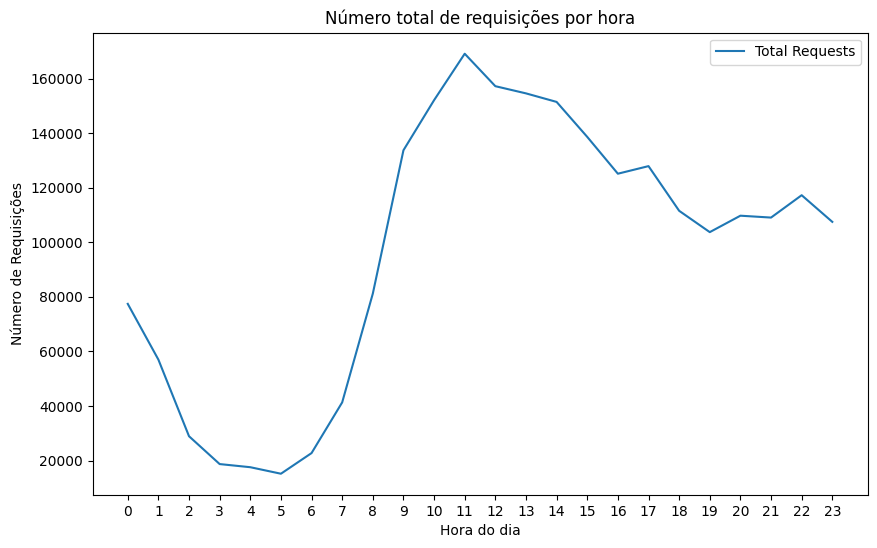

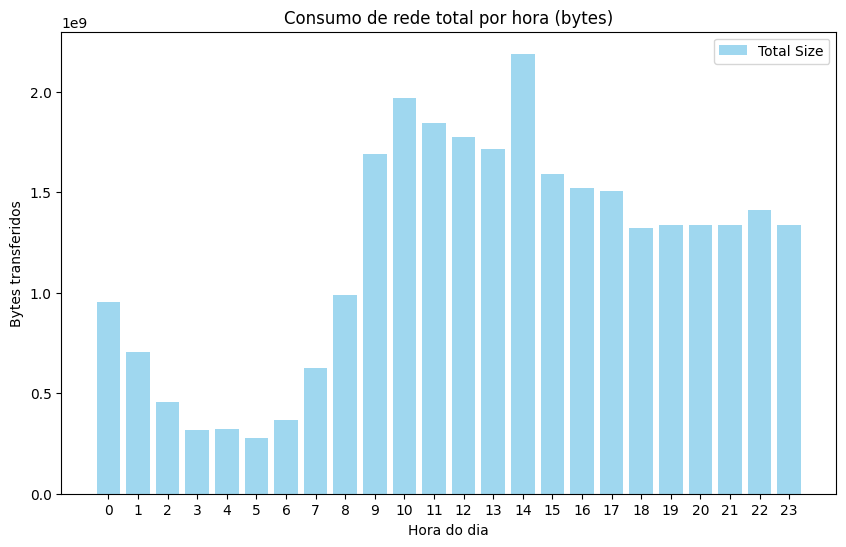

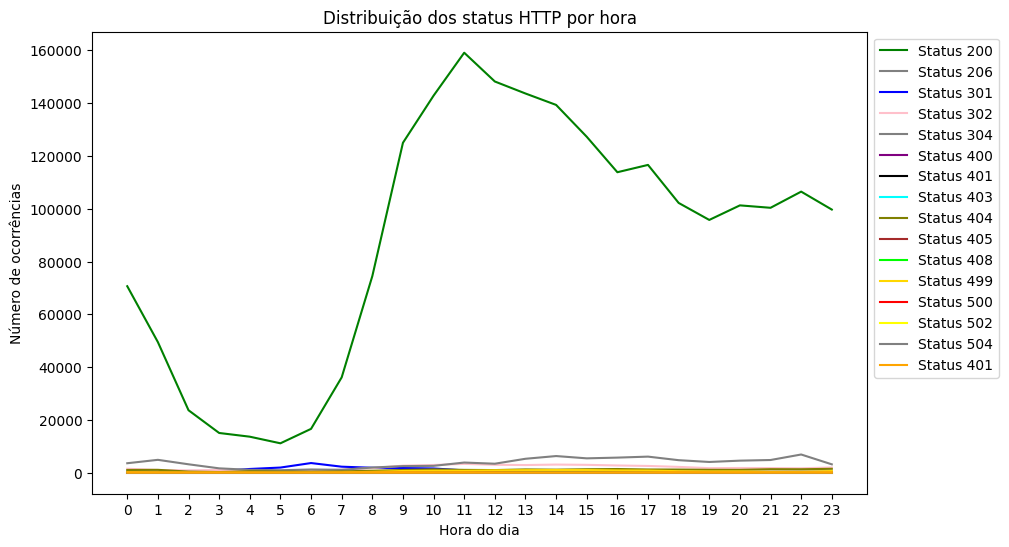

    hour     mean_size  median_size  variance_size  std_dev_size
0      0  12400.510051       4577.0   5.850702e+08  24188.223647
1      1  13169.430129       4620.0   7.404065e+08  27210.411153
2      2  16767.969621       5103.0   1.347002e+09  36701.519894
3      3  18283.197040       6389.0   1.275914e+09  35719.940403
4      4  19662.121259       7283.0   1.450758e+09  38088.823469
5      5  20896.579881      11108.0   1.382175e+09  37177.608313
6      6  18438.137241       6496.0   1.219843e+09  34926.250256
7      7  15111.024026       4424.0   9.437216e+08  30720.051719
8      8  12448.611893       3863.0   7.475078e+08  27340.588900
9      9  12227.659330       3573.0   9.167139e+08  30277.283604
10    10  12023.527462       3517.0   9.711094e+08  31162.627872
11    11  11834.952599       3466.0   9.670456e+08  31097.357488
12    12  11564.571963       3608.0   7.476552e+08  27343.284935
13    13  11975.721438       3857.0   9.264963e+08  30438.401179
14    14  12209.413671   

In [80]:
plt.style.use('default')

plt.figure(figsize=(10, 6))
plt.plot(hourly_grouped['hour'], hourly_grouped['total_requests'], label='Total Requests')
plt.title('Número total de requisições por hora')
plt.xlabel('Hora do dia')
plt.ylabel('Número de Requisições')
plt.xticks(range(0, 24))
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.bar(hourly_grouped['hour'], hourly_grouped['total_size'], color='skyblue', alpha=0.8, label='Total Size')
plt.title('Consumo de rede total por hora (bytes)')
plt.xlabel('Hora do dia')
plt.ylabel('Bytes transferidos')
plt.xticks(range(0, 24))
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(hourly_grouped['hour'], hourly_grouped['status_200'], label='Status 200', color='green')
plt.plot(hourly_grouped['hour'], hourly_grouped['status_206'], label='Status 206', color='gray')
plt.plot(hourly_grouped['hour'], hourly_grouped['status_301'], label='Status 301', color='blue')
plt.plot(hourly_grouped['hour'], hourly_grouped['status_302'], label='Status 302', color='pink')
plt.plot(hourly_grouped['hour'], hourly_grouped['status_304'], label='Status 304', color='gray')
plt.plot(hourly_grouped['hour'], hourly_grouped['status_400'], label='Status 400', color='purple')
plt.plot(hourly_grouped['hour'], hourly_grouped['status_401'], label='Status 401', color='black')
plt.plot(hourly_grouped['hour'], hourly_grouped['status_403'], label='Status 403', color='cyan')
plt.plot(hourly_grouped['hour'], hourly_grouped['status_404'], label='Status 404', color='olive')
plt.plot(hourly_grouped['hour'], hourly_grouped['status_405'], label='Status 405', color='brown')
plt.plot(hourly_grouped['hour'], hourly_grouped['status_408'], label='Status 408', color='lime')
plt.plot(hourly_grouped['hour'], hourly_grouped['status_499'], label='Status 499', color='gold')
plt.plot(hourly_grouped['hour'], hourly_grouped['status_500'], label='Status 500', color='red')
plt.plot(hourly_grouped['hour'], hourly_grouped['status_502'], label='Status 502', color='yellow')
plt.plot(hourly_grouped['hour'], hourly_grouped['status_504'], label='Status 504', color='gray')
plt.plot(hourly_grouped['hour'], hourly_grouped['status_401'], label='Status 401', color='orange')
plt.title('Distribuição dos status HTTP por hora')
plt.xlabel('Hora do dia')
plt.ylabel('Número de ocorrências')
plt.xticks(range(0, 24))
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

hourly_summary = new_logs_df.groupby('hour').agg(
    mean_size=('size', 'mean'),
    median_size=('size', 'median'),
    variance_size=('size', 'var'),
    std_dev_size=('size', 'std')  
).reset_index()

print(hourly_summary)

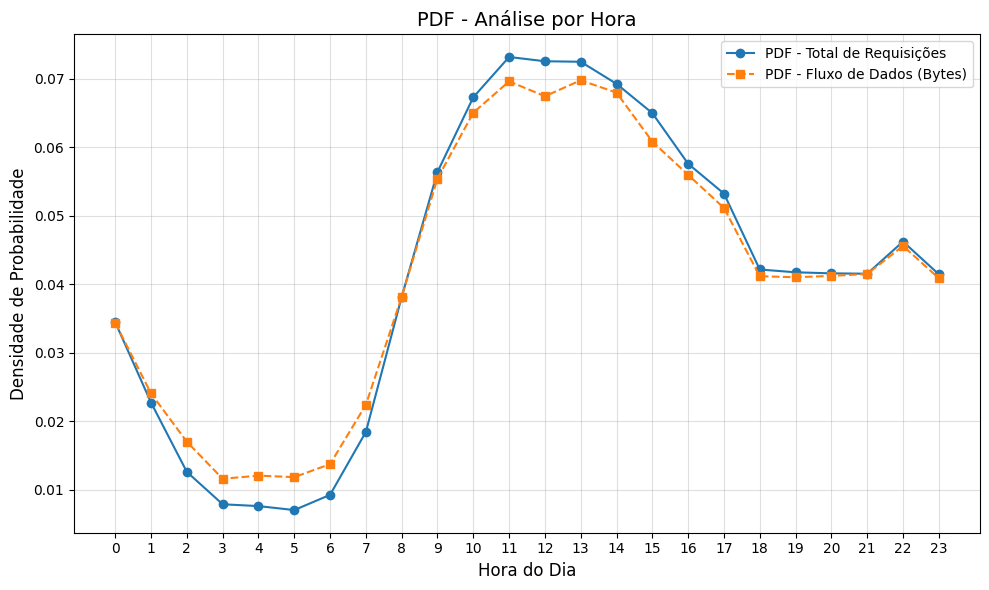

In [84]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

x = hourly_summary['hour']
y_requests = hourly_summary['total_requests']
y_size = hourly_summary['total_size']


pdf_requests = y_requests / y_requests.sum()
pdf_size = y_size / y_size.sum()


plt.figure(figsize=(10, 6))


plt.plot(x, pdf_requests, label="PDF - Total de Requisições", marker="o", linestyle="-")

plt.plot(x, pdf_size, label="PDF - Fluxo de Dados (Bytes)", marker="s", linestyle="--")

plt.title("PDF - Análise por Hora", fontsize=14)
plt.xlabel("Hora do Dia", fontsize=12)
plt.ylabel("Densidade de Probabilidade", fontsize=12)
plt.xticks(range(24))  
plt.grid(alpha=0.4)
plt.legend()
plt.tight_layout()

plt.show()


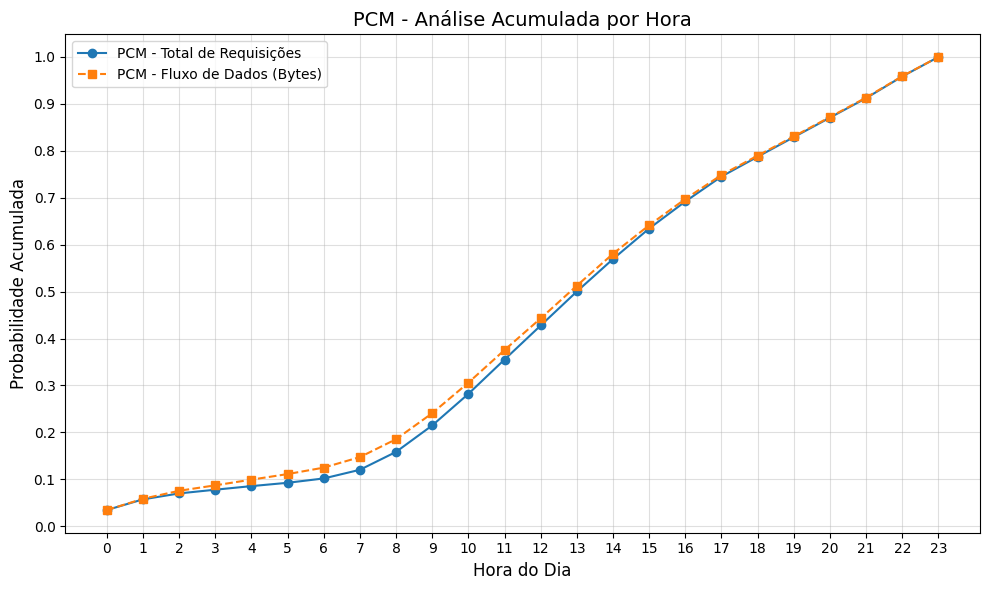

In [85]:
import pandas as pd
import matplotlib.pyplot as plt



pdf_requests = hourly_summary['total_requests'] / hourly_summary['total_requests'].sum()
pdf_size = hourly_summary['total_size'] / hourly_summary['total_size'].sum()

pcm_requests = pdf_requests.cumsum()
pcm_size = pdf_size.cumsum()

plt.figure(figsize=(10, 6))

plt.plot(hourly_summary['hour'], pcm_requests, label="PCM - Total de Requisições", marker="o", linestyle="-")

plt.plot(hourly_summary['hour'], pcm_size, label="PCM - Fluxo de Dados (Bytes)", marker="s", linestyle="--")

plt.title("PCM - Análise Acumulada por Hora", fontsize=14)
plt.xlabel("Hora do Dia", fontsize=12)
plt.ylabel("Probabilidade Acumulada", fontsize=12)
plt.xticks(range(24))  
plt.yticks([i * 0.1 for i in range(11)])  
plt.grid(alpha=0.4)
plt.legend()
plt.tight_layout()

plt.show()

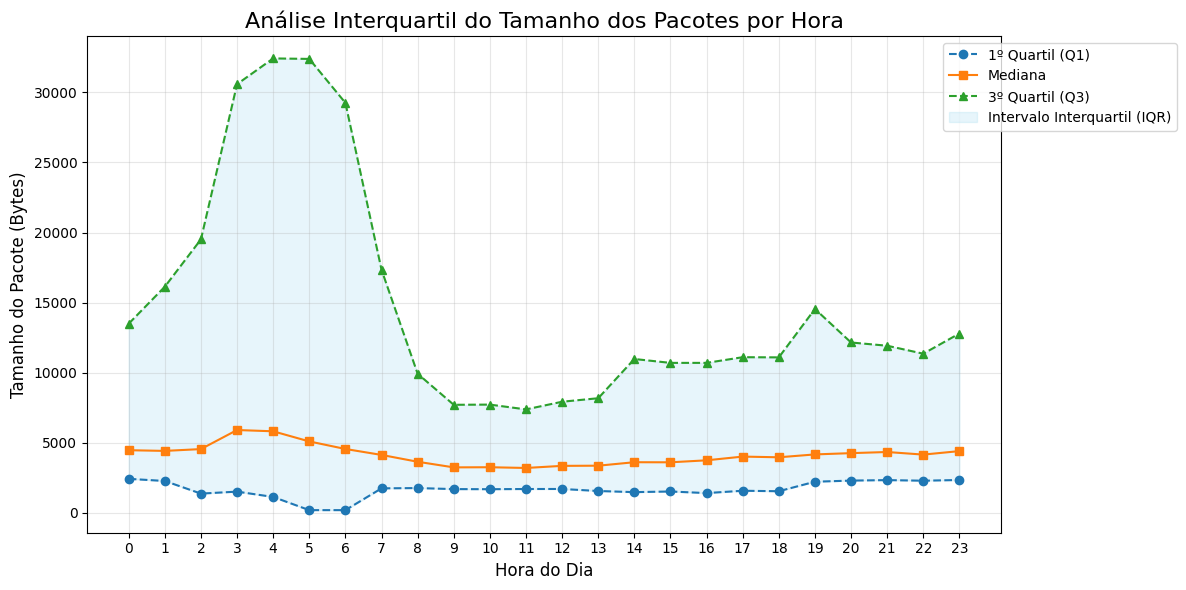

In [91]:
import matplotlib.pyplot as plt
import pandas as pd

hourly_iqr = filtered_logs.groupby('hour').agg(
    q1_size=('size', lambda x: x.quantile(0.25)),
    median_size=('size', 'median'),
    q3_size=('size', lambda x: x.quantile(0.75))
).reset_index()

hourly_iqr['iqr'] = hourly_iqr['q3_size'] - hourly_iqr['q1_size']

plt.figure(figsize=(12, 6))

plt.plot(hourly_iqr['hour'], hourly_iqr['q1_size'], label='1º Quartil (Q1)', linestyle='--', marker='o')
plt.plot(hourly_iqr['hour'], hourly_iqr['median_size'], label='Mediana', linestyle='-', marker='s')
plt.plot(hourly_iqr['hour'], hourly_iqr['q3_size'], label='3º Quartil (Q3)', linestyle='--', marker='^')

plt.fill_between(hourly_iqr['hour'], hourly_iqr['q1_size'], hourly_iqr['q3_size'], color='skyblue', alpha=0.2, label='Intervalo Interquartil (IQR)')

plt.title('Análise Interquartil do Tamanho dos Pacotes por Hora', fontsize=16)
plt.xlabel('Hora do Dia', fontsize=12)
plt.ylabel('Tamanho do Pacote (Bytes)', fontsize=12)
plt.xticks(hourly_iqr['hour'], fontsize=10)
plt.yticks(fontsize=10)
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1), fontsize=10)  
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()
